In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


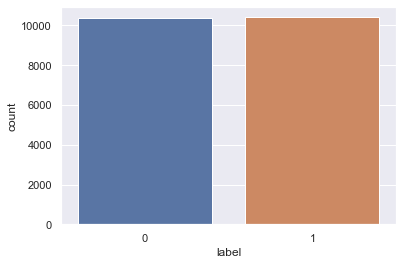

In [3]:
sns.countplot(train.label);

#### Training set is balanced {0 : 'reliable', 1 : 'unreliable'}

In [4]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [5]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

#### There are some missing values in title, author and text columns. We will fill them with spaces and combine these columns

In [7]:
# Preprocessing
train = train.fillna(' ')
test = test.fillna(' ')

train['all_text']= train['title'] + ' ' + train['author'] + ' ' + train['text']
test['all_text']= test['title'] + ' ' + test['author'] + ' ' + test['text']

In [8]:
# drop title, author and text columns
train.drop(columns=['title', 'author', 'text'], inplace=True)
test.drop(columns=['title', 'author', 'text'], inplace=True)

train.head()

,id,label,all_text
0,0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,1,Why the Truth Might Get You Fired Consortiumne...
3,3,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,1,Iranian woman jailed for fictional unpublished...


In [9]:
# Remove punctuations
import string

def remove_punct(text):
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    return text_nopunct

train['clean_text'] = train['all_text'].apply(lambda x : remove_punct(x))
test['clean_text'] = test['all_text'].apply(lambda x : remove_punct(x))

train.head()

,id,label,all_text,clean_text
0,0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide We Didn’t Even See Comey’s Lett...
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",FLYNN Hillary Clinton Big Woman on Campus Bre...
2,2,1,Why the Truth Might Get You Fired Consortiumne...,Why the Truth Might Get You Fired Consortiumne...
3,3,1,15 Civilians Killed In Single US Airstrike Hav...,15 Civilians Killed In Single US Airstrike Hav...
4,4,1,Iranian woman jailed for fictional unpublished...,Iranian woman jailed for fictional unpublished...


### Feature Engineering

In [10]:
# text length
train['text_len'] = train['all_text'].apply(lambda x: len(x)- x.count(' '))
test['text_len'] = test['all_text'].apply(lambda x: len(x)- x.count(' '))

# punctuation percentage
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(' ')), 3)*100

train['punct%'] = train['all_text'].apply(lambda x : count_punct(x))
test['punct%'] = test['all_text'].apply(lambda x : count_punct(x))

train.head()

,id,label,all_text,clean_text,text_len,punct%
0,0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide We Didn’t Even See Comey’s Lett...,4191,2.1
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",FLYNN Hillary Clinton Big Woman on Campus Bre...,3494,2.2
2,2,1,Why the Truth Might Get You Fired Consortiumne...,Why the Truth Might Get You Fired Consortiumne...,6472,2.9
3,3,1,15 Civilians Killed In Single US Airstrike Hav...,15 Civilians Killed In Single US Airstrike Hav...,2747,1.9
4,4,1,Iranian woman jailed for fictional unpublished...,Iranian woman jailed for fictional unpublished...,878,1.8


In [11]:
train['text_len'].max()

122571

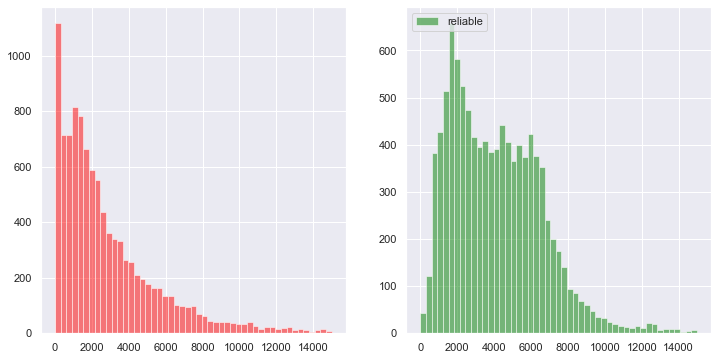

In [12]:
# Compare variation in text length for labels
plt.figure(figsize=(12,6))

bins = np.linspace(0,15000,50)

plt.subplot(1,2,1)
plt.hist(train[train.label==1]['text_len'], bins=bins, alpha=0.5, label='unreliable', color='red')

plt.subplot(1,2,2)
plt.hist(train[train.label==0]['text_len'], bins=bins, alpha=0.5, label='reliable', color='green')
plt.legend(loc='upper left')
plt.show();

#### Text length in reliable sources are around 2000 to 6000. While in unreliable sources, it is generally less than 4000

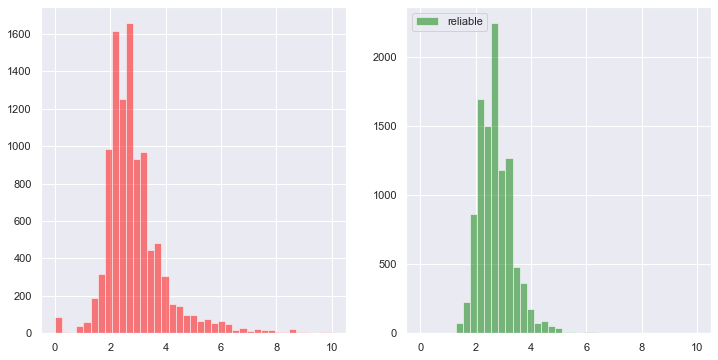

In [13]:
# Compare variation in puctuation percentage for labels
plt.figure(figsize=(12,6))

bins = np.linspace(0,10,40)

plt.subplot(1,2,1)
plt.hist(train[train.label==1]['punct%'], bins=bins, alpha=0.5, label='unreliable', color='red')
plt.subplot(1,2,2)
plt.hist(train[train.label==0]['punct%'], bins=bins, alpha=0.5, label='reliable', color='green')
plt.legend(loc='upper left')
plt.show();

#### Not much difference in puctuation percentage other than some outliers either side of the peak in unreliable sources

### Modeling

In [14]:
train.drop(columns=['all_text'], inplace=True)
test.drop(columns=['all_text'], inplace=True)

In [15]:
# Split training set in train and validation sets
from sklearn.model_selection import train_test_split

X = train[['clean_text', 'text_len', 'punct%']]
y = train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Vectorize the text columns
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# counts = count_vectorizer.fit_transform(X_train['clean_text'].values)
tfidf_train = vectorizer.fit_transform(X_train['clean_text'].values)

# val_counts = count_vectorizer.transform(X_val['clean_text'].values)
tfidf_val = vectorizer.transform(X_val['clean_text'].values)


X_train_vect = pd.concat([X_train[['text_len', 'punct%']].reset_index(drop=True), pd.DataFrame(tfidf_train.toarray())], axis=1)
X_val_vect = pd.concat([X_val[['text_len', 'punct%']].reset_index(drop=True), pd.DataFrame(tfidf_val.toarray())], axis=1)

X_train_vect.head()

,text_len,punct%,0,1,2,3,4,5,6,7,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,3783,3.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,935,3.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6291,2.1,0.0,0.0,0.0,0.0,0.0,0.027453,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2130,2.7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3118,2.6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Normalize and scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_vect)
X_val_scaled = scaler.transform(X_val_vect)

In [19]:
# Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train_scaled, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train_scaled, y_train)))
print('Accuracy of NB classifier on validation set: {:.2f}'.format(NB.score(X_val_scaled, y_val)))

Accuracy of NB  classifier on training set: 0.93
Accuracy of NB classifier on validation set: 0.92


In [20]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, solver='newton-cg', penalty='l2')
logreg.fit(X_train_scaled, y_train)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'.format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of Logistic Regression classifier on validation set: {:.2f}'.format(logreg.score(X_val_scaled, y_val)))

Accuracy of Logistic Regression classifier on training set: 1.00
Accuracy of Logistic Regression classifier on validation set: 0.97


In [21]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf.score(X_train_scaled, y_train)))
print('Accuracy of Random Forest classifier on validation set: {:.2f}'.format(rf.score(X_val_scaled, y_val)))

Accuracy of Random Forest classifier on training set: 0.84
Accuracy of Random Forest classifier on validation set: 0.82


In [35]:
# xgboost classifier
from xgboost.sklearn import XGBClassifier
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': True,
    'n_estimators': 20,
    'n_jobs' : -1
}

xgb_clf = XGBClassifier(**params).fit(X_train_scaled, y_train)

print('Accuracy of XGBoost classifier on training set: {:.2f}'.format(xgb_clf.score(X_train_scaled, y_train)))
print('Accuracy of XGBoost classifier on validation set: {:.2f}'.format(xgb_clf.score(X_val_scaled, y_val)))

Accuracy of XGBoost classifier on training set: 0.97
Accuracy of XGBoost classifier on validation set: 0.97


In [36]:
# Stacking the classifiers and voting
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('Naive_Bayes', NB),  ('Logistic_Regression', logreg), ('Random_Forest', rf), ('XGBoost', xgb_clf)], voting='soft')
voting_clf.fit(X_train_scaled, y_train)

print('Accuracy of Stacked classifier on training set: {:.2f}'.format(voting_clf.score(X_train_scaled, y_train)))
print('Accuracy of Stacked classifier on validation set: {:.2f}'.format(voting_clf.score(X_val_scaled, y_val)))

Accuracy of Stacked classifier on training set: 0.99
Accuracy of Stacked classifier on validation set: 0.98


In [44]:
# Predict on cross-validation set
y_pred = voting_clf.predict(X_val_scaled)

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy_score:', round(accuracy_score(y_val, y_pred),2))
print('--------------------------------------')
print(classification_report(y_val, y_pred, labels=[0,1]))

accuracy_score: 0.98
--------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2132
           1       0.98      0.98      0.98      2028

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



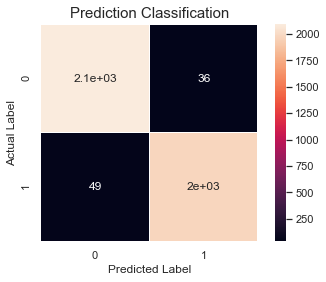

In [38]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, linewidths=0.5, square=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Prediction Classification', size=15);

In [39]:
# Preprocess test set 
X_test = test[['clean_text', 'text_len', 'punct%']]

# Vectorization
tfidf_test = vectorizer.transform(X_test['clean_text'].values)
X_test_vect = pd.concat([X_test[['text_len', 'punct%']].reset_index(drop=True), pd.DataFrame(tfidf_test.toarray())], axis=1)

# Scaling
X_test_scaled = scaler.transform(X_test_vect)

In [40]:
# Make prediction on test set
predictions = voting_clf.predict(X_test_scaled)
results = pd.Series(predictions, name="label")

df_result = pd.concat([pd.Series(test.id, name = "id"), results], axis = 1)
df_result['id'] = df_result['id'].astype(int)
df_result.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [41]:
df_result.to_csv('submit.csv', index=False)